In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from collections import defaultdict

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
random.seed(42)

## Environment

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

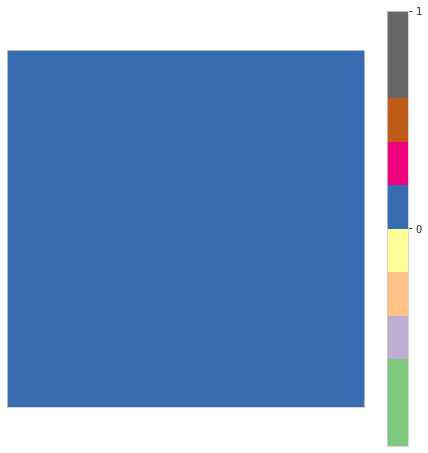

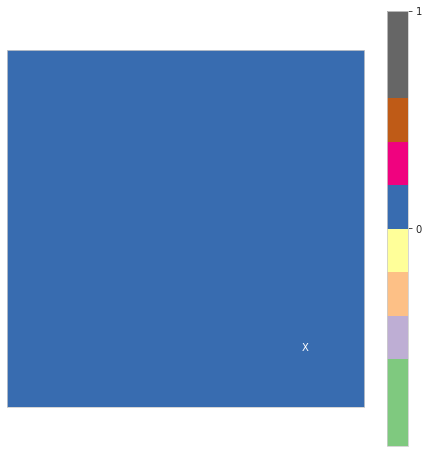

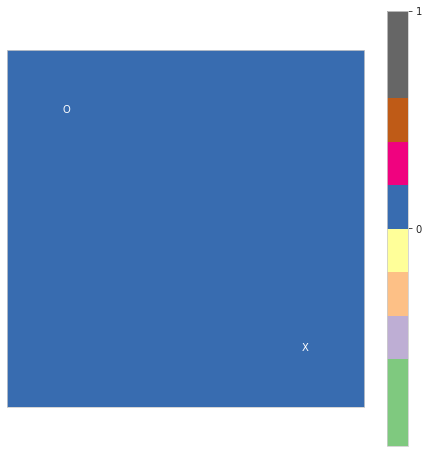

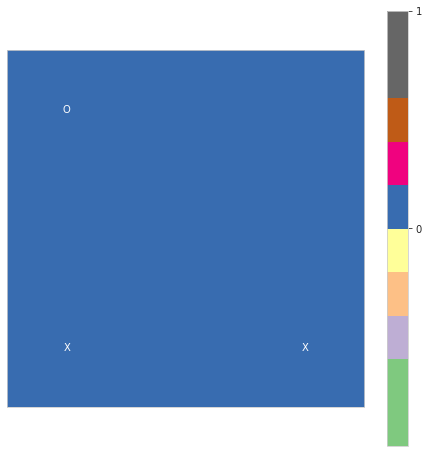

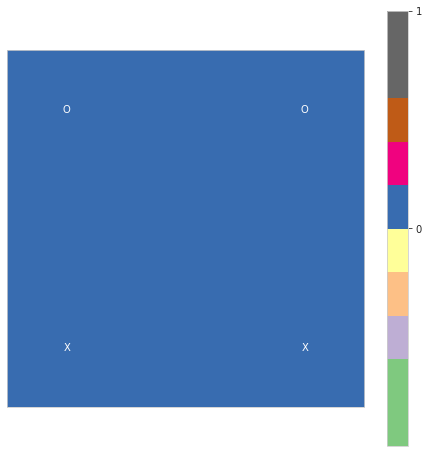

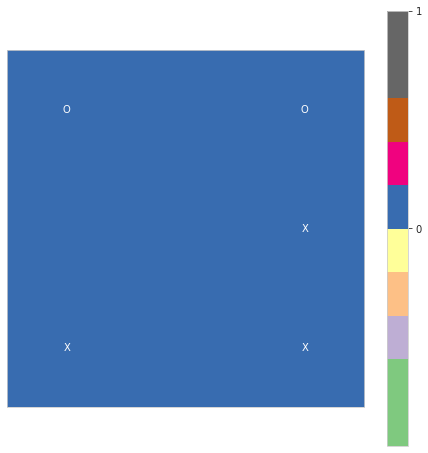

Нолики выиграли!


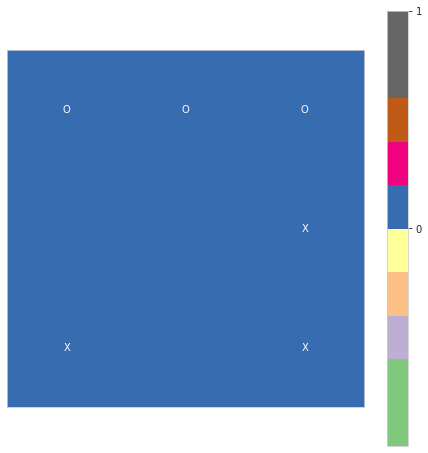

In [6]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=10)

## Q-learning

In [ ]:
def board_to_number(state):
  if len(state) == 0:
    return 0

  board_actions = [env.int_from_action(x) for x in state]
  initial = np.zeros(np.max(board_actions) + 1, dtype=np.int16)

  for i in board_actions:
    initial[i] = 1

  return int("".join(str(i) for i in initial), 2)

In [ ]:
def encode_state(current_state):
  return (current_state[0], board_to_number(current_state[1]), current_state[2])

In [ ]:
def policyFunction(epsilon, action_size, Q_state):

  action_probabilities = np.ones(action_size, dtype = float) * epsilon / action_size

  Q_states_available = np.array(Q_state)
  idx = np.where(Q_states_available == Q_states_available.max())

  for j in idx:
    action_probabilities[j] += (1.0 - epsilon) / len(idx)

  return random.choices(range(action_size), weights=action_probabilities)[0] 

In [ ]:
def Q_step(env, Q, policy, gamma, alpha, epsilon):
    env.reset()
    
    curr_state = encode_state(env.getState())

    done = False

    agent_starts = random.choice([0, 1])

    if not agent_starts:
      curr_state, reward_opponent, done, _ = env.step(random.choice(env.getEmptySpaces()))
      curr_state = encode_state(curr_state)

    while not done:

      curr_act_agent = policy(epsilon, env.n_cols * env.n_rows,  Q[curr_state])
      next_state_agent, reward_agent, done, _ = env.step(env.action_from_int(curr_act_agent))   
      next_state_agent = encode_state(next_state_agent)

      if not agent_starts:
        if reward_agent == -1:
          reward_agent = 1

      if done:
        Q[curr_state][curr_act_agent] += alpha * (reward_agent + gamma * np.max(Q[next_state_agent])  - Q[curr_state][curr_act_agent]) 
        break


      next_state_oppos, reward_opponent, done, _ = env.step(random.choice(env.getEmptySpaces()))
      next_state_oppos = encode_state(next_state_oppos)

      if not agent_starts:
        if reward_opponent == 1:
          reward_opponent = -1

      if reward_opponent == -10:
        reward_opponent = 1
          

      Q[curr_state][curr_act_agent] += alpha * (reward_opponent + gamma * np.max(Q[next_state_oppos])  - Q[curr_state][curr_act_agent]) 


      curr_state = next_state_oppos
           
    return Q

In [ ]:
def conduct_experiments_pi(env, policy, Q, num_experiments=1000):
    total_reward = []

    for i in range(num_experiments):
        total_reward.append(0)

        env_starts = random.choice([0, 1])

        env.reset()
        curr_state = encode_state(env.getState())
        
        if env_starts:
          curr_state, reward_opponent, done, _ = env.step(random.choice(env.getEmptySpaces()))
          curr_state = encode_state(curr_state)
        
        done = False
        while not done:

            ## Our step
            curr_act = policy(0, env.n_cols * env.n_rows,  Q[curr_state])
            curr_state, reward_our_alg, done, _ = env.step(env.action_from_int(curr_act))
            curr_state = encode_state(curr_state)


            if env_starts:
              if reward_our_alg == -1:
                total_reward[-1] -= reward_our_alg
              elif reward_our_alg == -10:
                total_reward[-1] += reward_our_alg
            else:
              total_reward[-1] += reward_our_alg


            if done:
              break

            ## Random step
            curr_state, reward_opponent, done, _ = env.step(random.choice(env.getEmptySpaces()))
            curr_state = encode_state(curr_state)

            if env_starts:
              total_reward[-1] -= reward_opponent
            else:
              total_reward[-1] += reward_opponent

            if done:
              break

    env.close()
    return np.sum(total_reward)

In [ ]:
def exp_with_results(env, total_episodes, exp_freq, gamma, alpha, epsilon):
  results_Qlearn = []

  Q_arr = defaultdict(lambda: np.zeros(env.n_rows * env.n_cols))

  for n in range(0, total_episodes + 1):
      Q_arr = Q_step(env, Q_arr, policyFunction, gamma, alpha, epsilon)

      if n % exp_freq == 0:
          print("\rEpisode {}/{}.".format(n, total_episodes), end="")
          result = conduct_experiments_pi(env, policyFunction, Q_arr)
          results_Qlearn.append(result)

  env.close()
  return results_Qlearn

In [ ]:
total_episodes = 100000
exp_freq = 1000
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
gamma = 1.0
alpha = 0.1
epsilon = 0.1

Episode 100000/100000.last reward:894


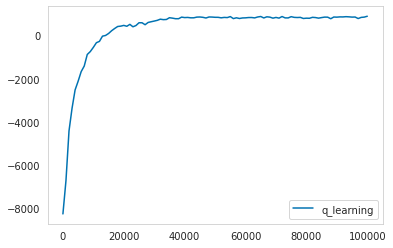

In [ ]:
res_reward = exp_with_results(env, total_episodes, exp_freq, gamma, alpha, epsilon)

print("last reward:" + str(res_reward[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), res_reward, label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

# reward 894 plays from 1000, good score

Episode 200000/200000.last reward:-5917


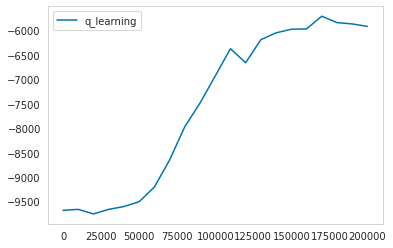

In [ ]:
total_episodes = 200000
exp_freq = 10000
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
gamma = 1.0
alpha = 0.1
epsilon = 0.1
res_reward = exp_with_results(env, total_episodes, exp_freq, gamma, alpha, epsilon)

print("last reward:" + str(res_reward[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), res_reward, label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

## DQN

In [ ]:
def encode_state_dqn(state, n_cols):
  state_to_itterate = [int(i) for i in state[0]]
  result = np.zeros(( 3, n_cols, n_cols), dtype=np.int16)

  for i in range(3):
    idx = np.where(np.array(state_to_itterate) == i)
    for id in idx[0]:
      result[i][id // n_cols][id % n_cols] = 1

  return result

In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [ ]:
class Network(nn.Module):
    def __init__(self, n_cols, n_rows):
        nn.Module.__init__(self)
        self.conv_out_size = 5
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.conv = nn.Conv2d(3, self.conv_out_size, kernel_size=3, stride=1, padding=1)
        self.l2 = nn.Linear(self.conv_out_size * n_cols * n_rows, n_cols * n_rows)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, self.conv_out_size * self.n_cols * self.n_rows)
        x = self.l2(x)
        return x

In [ ]:
class DQNLearning():
    def __init__(self, env, n_rows, n_cols, model, optim,  eps_init = 0.9, eps_final = 0.05, eps_decay = 1000, replay_memory_size=100000, gamma=1.0, batch_size=64):
        self.env = env
        self.n_cols = n_cols
        self.action_size = n_rows * n_cols
        self.model = model
        self.memory = ReplayMemory(replay_memory_size)
        self.optimizer = optim
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.eps_init, self.eps_final, self.eps_decay = eps_init, eps_final, eps_decay
        self.num_step = 0

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):

        self.env.reset()
        state = encode_state_dqn(self.env.getState(), self.n_cols)
        num_step = 0

        x_plays = random.choice([0, 1])

        if not x_plays:
          state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
          state = encode_state_dqn(state, self.n_cols)

        while True:
          state_tensor = torch.tensor([state], dtype=torch.float32)
          with torch.no_grad():
            if greedy:
              action = self.select_greedy_action(state_tensor)
            else:
              action = self.select_action(state_tensor)

          next_state, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))
          next_state = encode_state_dqn(next_state, self.n_cols)
          next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

          if not done:
            next_state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
            next_state = encode_state_dqn(next_state, self.n_cols)
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

          if not x_plays:
            if reward in [-1, 1]:
              reward = reward * -1

          transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
          self.memory.store(transition)

          if do_learning:
              self.learn()

          if done:
              break

          state = next_state
          num_step += 1

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
def conduct_experiments_dqs(env, model, n_cols, num_experiments=1000):
    total_reward = []

    for i in range(num_experiments):
        total_reward.append(0)

        env_starts = random.choice([0, 1])

        env.reset()
        curr_state = encode_state_dqn(env.getState(), n_cols)
        
        if env_starts:
          curr_state, reward_opponent, done, _ = env.step(random.choice(env.getEmptySpaces()))
          curr_state = encode_state_dqn(curr_state, n_cols)
        
        done = False
        while not done:

            ## Our step
            curr_act = model(torch.tensor([curr_state], dtype=torch.float32)).data
            curr_act = np.argmax(curr_act.detach().numpy()[0])

            curr_state, reward_our_alg, done, _ = env.step(env.action_from_int(curr_act))
            curr_state = encode_state_dqn(curr_state, n_cols)

            if env_starts:
              if reward_our_alg == -1:
                total_reward[-1] += 1
              elif reward_our_alg == -10:
                total_reward[-1] += reward_our_alg
            else:
              total_reward[-1] += reward_our_alg


            if done:
              break

            ## Random step
            curr_state, reward_opponent, done, _ = env.step(random.choice(env.getEmptySpaces()))
            curr_state = encode_state_dqn(curr_state, n_cols)

            if env_starts:
              total_reward[-1] -= reward_opponent
            else:
              total_reward[-1] += reward_opponent

            if done:
              break

    env.close()
    return np.sum(total_reward)

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
N_EPOCHS = 3000
N_EXP = 300
EPS_INIT  = 0.9
EPS_FINAL = 0.05
EPS_DECAY = 5000
RM_SIZE = 100000
GAMMA = 0.92
BATCH_SIZE = 128
LR = 0.001
EXP_NUMBER = 1000

In [ ]:
model = Network(N_COLS, N_ROWS)
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
optimizer = optim.Adam(model.parameters(), LR)
dqn = DQNLearning(env, N_ROWS, N_COLS, model, optimizer, EPS_INIT, EPS_FINAL, EPS_DECAY, RM_SIZE, GAMMA, BATCH_SIZE)

res = []
print("%s\tStarting training..." % (datetime.now().time()))
for e in range(N_EPOCHS + 1):
  dqn.run_episode(e)
  if e % N_EXP == 0:
    print("\rEpisode {}/{}.".format(e, N_EPOCHS), end="")
    res.append(conduct_experiments_dqs(env, model, N_COLS, EXP_NUMBER))
print("%s\t\t...done!" % (datetime.now().time()))

10:40:26.401347	Starting training...
Episode 3000/3000.10:41:18.327708		...done!


last reward:0.382


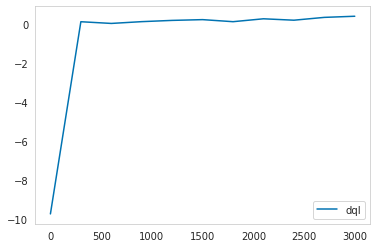

In [ ]:
res = [number / EXP_NUMBER for number in res]
print("last reward:" + str(res[-1]))
plt.plot(np.arange(0, N_EPOCHS + 1, N_EXP), res, label="dql")
plt.grid()
_ = plt.legend()
plt.show()

In [ ]:
N_ROWS, N_COLS, N_WIN = 5, 5, 5
N_EPOCHS = 10000
N_EXP = 500
EPS_INIT  = 0.9
EPS_FINAL = 0.05
EPS_DECAY = 5000
RM_SIZE = 100000
GAMMA = 0.85
BATCH_SIZE = 128
LR = 0.001
EXP_NUMBER = 1000

In [ ]:
model = Network(N_COLS, N_ROWS)
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
optimizer = optim.Adam(model.parameters(), LR)
dqn = DQNLearning(env, N_ROWS, N_COLS, model, optimizer, EPS_INIT, EPS_FINAL, EPS_DECAY, RM_SIZE, GAMMA, BATCH_SIZE)

res = []
print("%s\tStarting training..." % (datetime.now().time()))
for e in range(N_EPOCHS + 1):
  dqn.run_episode(e)
  if e % N_EXP == 0:
    print("\rEpisode {}/{}.".format(e, N_EPOCHS), end="")
    res.append(conduct_experiments_dqs(env, model, N_COLS, EXP_NUMBER))
print("%s\t\t...done!" % (datetime.now().time()))

10:43:50.909643	Starting training...
Episode 10000/10000.10:51:36.232186		...done!


last reward:0.482


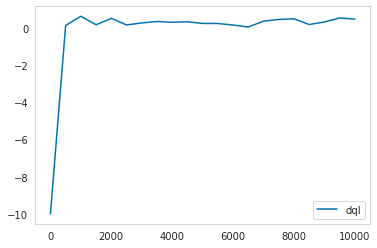

In [ ]:
res = [number / EXP_NUMBER for number in res]
print("last reward:" + str(res[-1]))
plt.plot(np.arange(0, N_EPOCHS + 1, N_EXP), res, label="dql")
plt.grid()
_ = plt.legend()
plt.show()

In [ ]:
class DuelingDQN(nn.Module):
    def __init__(self, n_cols, n_rows):
        nn.Module.__init__(self)
        self.conv_out_size = 5
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.conv = nn.Conv2d(3, self.conv_out_size, kernel_size=3, stride=1, padding=1)
        self.l2 = nn.Linear(self.conv_out_size * n_cols * n_rows, 64)

        self.fc_value = nn.Linear(64, 1)
        self.fc_adv = nn.Linear(64, n_cols * n_rows)
        

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, self.conv_out_size * self.n_cols * self.n_rows)
        x = self.l2(x)

        value = self.fc_value(x)
        adv = self.fc_adv(x)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage
        return Q

In [ ]:
N_ROWS, N_COLS, N_WIN = 5, 5, 5
N_EPOCHS = 10000
N_EXP = 500
EPS_INIT  = 0.9
EPS_FINAL = 0.05
EPS_DECAY = 5000
RM_SIZE = 100000
GAMMA = 0.85
BATCH_SIZE = 128
LR = 0.0001
EXP_NUMBER = 1000

In [ ]:
dueling_model = DuelingDQN(N_COLS, N_ROWS)
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
optimizer = optim.Adam(dueling_model.parameters(), LR)
dqn = DQNLearning(env, N_ROWS, N_COLS, dueling_model, optimizer, EPS_INIT, EPS_FINAL, EPS_DECAY, RM_SIZE, GAMMA, BATCH_SIZE)

res = []
print("%s\tStarting training..." % (datetime.now().time()))
for e in range(N_EPOCHS + 1):
  dqn.run_episode(e)
  if e % N_EXP == 0:
    print("\rEpisode {}/{}.".format(e, N_EPOCHS), end="")
    res.append(conduct_experiments_dqs(env, dueling_model, N_COLS, 1000))
print("%s\t\t...done!" % (datetime.now().time()))

15:37:06.365861	Starting training...
Episode 10000/10000.15:46:54.784890		...done!


last reward:0.638


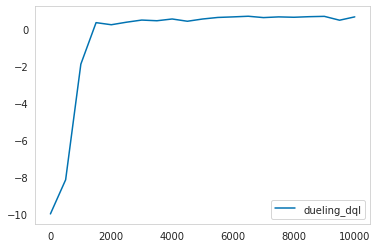

In [ ]:
res = [number / EXP_NUMBER for number in res]
print("last reward:" + str(res[-1]))
plt.plot(np.arange(0, N_EPOCHS + 1, N_EXP), res, label="dueling_dql")
plt.grid()
_ = plt.legend()
plt.show()

## MCTS

In [8]:
class Node():

  def __init__(self, parent, state):
    self.parent = parent
    self.state = state
    self.action_nodes = {}
    self.win_x = 0
    self.win_o = 0
    self.draw = 0
    self.number_of_visits = 0

  def score(self, reward, C, number_of_visits_par, number_of_vis):
      return reward / number_of_vis + C * np.sqrt(np.log(number_of_visits_par) / number_of_vis)

  
  def best_child(self, C, o_plays):
      best_action = -1
      current_val = -1
      best_child = None

      untried_node, untried_action = self.untried_actions()
      if untried_node != None:
        return untried_node, untried_action


      for action, child in self.action_nodes.items():
        if o_plays:
          reward = child.win_o + child.draw
        else:
          reward = child.win_x 
        
        score_res = self.score(reward, C, self.number_of_visits, child.number_of_visits)
        
        if score_res > current_val:
          best_action = action
          current_val = score_res
          best_child = child

      return best_action, best_child


  def untried_actions(self):
    for action, node in self.action_nodes.items():
      if node.number_of_visits == 0:
        return action, node
    
    return None, None
        
  
  def isTerminal(self):
    return len(self.action_nodes) == 0


  def encode_state_with_action(self, current_state, action, x_plays):
    if x_plays:
      state = current_state[:action] + "2" + current_state[action+1:]
    else:
      state = current_state[:action] + "0" + current_state[action+1:]
    
    return state


  def expand(self, available_actions, x_plays):
    for action in available_actions:
      self.action_nodes[action] = Node(self, self.encode_state_with_action(self.state, action, x_plays))


  def get_child_by_action(self, action):
    if action in self.action_nodes:
      return self.action_nodes[action]
    else:
      return None


  def backpropagate(self, result):
    if result == 1:
      self.win_x += 1
    elif result == 0:
      self.win_o += 1
    else:
      self.draw += 1

    self.number_of_visits += 1

    if self.parent != None:
      self.parent.backpropagate(result)

  def new(self):
    return self.number_of_visits == 0


In [9]:
def rollout(env):
  done = False
  while not done:
    action = random.choice(env.getEmptySpaces())
    curr_state, reward, done, _ = env.step(action)

  return reward

In [10]:
class MCTS():
  def __init__(self, state, N_ACTIONS):
    self.root = Node(None, state)
    self.root.expand(range(N_ACTIONS), True)

In [11]:
def train(env, tree, NUM_EPOCHS, C):
    env.reset()
    state = env.getState()[0]
    done = False
    node = tree.root

    env_starts = random.choice([0, 1])

    if env_starts:
      action = random.choice(env.getEmptySpaces())
      curr_state, reward, done, _ = env.step(action)
      node = node.get_child_by_action(env.int_from_action(action))

    rand_plays = True
    while not node.isTerminal() and not done:
      if not rand_plays:
        action, next_node = node.best_child(C, env_starts)
        curr_state, reward, done, _ = env.step(env.action_from_int(action))
        node = next_node
        rand_plays = True
      else:
        action = random.choice(env.getEmptySpaces())
        curr_state, reward, done, _ = env.step(action)
        node = node.get_child_by_action(env.int_from_action(action))
        rand_plays = False

    
    if done:
      node.backpropagate(reward)
    elif node.isTerminal:

      if env_starts and rand_plays:
        x_plays = True
      elif not env_starts and rand_plays:
        x_plays = False
      elif env_starts and not rand_plays:
        x_plays = False
      else:
        x_plays = True

      available_actions = [env.int_from_action(act) for act in env.getEmptySpaces()]
      if not node.new():
        node.expand(available_actions, x_plays)
        _, node = node.best_child(C, x_plays)

      result = rollout(env)
      node.backpropagate(result)
      

In [12]:
def conduct_experiments_mcts(env, tree, NUM_EPOCHS_TEST):

  total_reward = 0

  for i in range(NUM_EPOCHS_TEST):
    env.reset()
    state = env.getState()[0]
    done = False
    node = tree.root

    env_starts = random.choice([0, 1])

    if env_starts:
      action = random.choice(env.getEmptySpaces())
      curr_state, reward, done, _ = env.step(action)
      node = node.get_child_by_action(env.int_from_action(action))


    rand_plays = True
    while not done and not node.isTerminal():
      if not rand_plays:
        action, next_node = node.best_child(0, env_starts)
        curr_state, reward, done, _ = env.step(env.action_from_int(action))
        node = next_node
        rand_plays = True
      else:
        action = random.choice(env.getEmptySpaces())
        curr_state, reward, done, _ = env.step(action)
        node = node.get_child_by_action(env.int_from_action(action))
        rand_plays = False

    
    if done:
      if env_starts:
        total_reward -= reward
      else:
        total_reward += reward

    elif node.isTerminal():

      while not done:
        action = random.choice(env.getEmptySpaces())
        curr_state, reward, done, _ = env.step(action)

      if env_starts:
        total_reward -= reward
      else:
        total_reward += reward

  return total_reward
     
      

In [13]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
N_EPOCHS = 100000
N_PLAYS_TEST = 10000
N_TEST = 5000
N_ACTIONS = N_ROWS * N_COLS
C = 0.3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
env.reset()
tree = MCTS(env.getState()[0], N_ACTIONS)

In [15]:
res = []
for i in range(N_EPOCHS + 1):
  train(env, tree, N_EPOCHS, C)

  if i % N_TEST == 0:
    print("\rEpisode {}/{}.".format(i, N_EPOCHS), end="")
    res.append(conduct_experiments_mcts(env, tree, N_PLAYS_TEST))

Episode 100000/100000.

last reward:0.7482


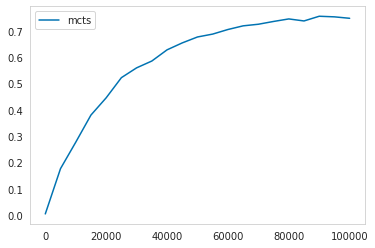

In [16]:
res = [number / N_PLAYS_TEST for number in res]
print("last reward:" + str(res[-1]))
plt.plot(np.arange(0, N_EPOCHS + 1, N_TEST), res, label="mcts")
plt.grid()
_ = plt.legend()
plt.show()

In [17]:
N_ROWS, N_COLS, N_WIN = 5, 5, 4
N_EPOCHS = 500000
N_PLAYS_TEST = 10000
N_TEST = 50000
N_ACTIONS = N_ROWS * N_COLS
C = 0.3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
env.reset()
tree = MCTS(env.getState()[0], N_ACTIONS)

In [18]:
res = []
for i in range(N_EPOCHS + 1):
  train(env, tree, N_EPOCHS, C)

  if i % N_TEST == 0:
    print("\rEpisode {}/{}.".format(i, N_EPOCHS), end="")
    res.append(conduct_experiments_mcts(env, tree, N_PLAYS_TEST))

Episode 500000/500000.

last reward:0.1058


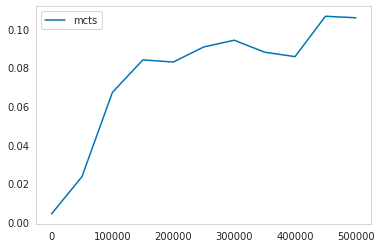

In [19]:
res = [number / N_PLAYS_TEST for number in res]
print("last reward:" + str(res[-1]))
plt.plot(np.arange(0, N_EPOCHS + 1, N_TEST), res, label="mcts")
plt.grid()
_ = plt.legend()
plt.show()

In [ ]:
N_ROWS, N_COLS, N_WIN = 5, 5, 5
N_EPOCHS = 1000000
N_PLAYS_TEST = 10000
N_TEST = 10000
N_ACTIONS = N_ROWS * N_COLS
C = 0.2
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
env.reset()
tree = MCTS(env.getState()[0], N_ACTIONS)

In [ ]:
res = []
for i in range(N_EPOCHS + 1):
  train(env, tree, N_EPOCHS, C)

  if i % N_TEST == 0:
    print("\rEpisode {}/{}.".format(i, N_EPOCHS), end="")
    res.append(conduct_experiments_mcts(env, tree, N_PLAYS_TEST))

Episode 1000000/1000000.

last reward:0.0128


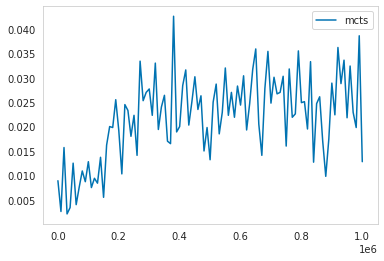

In [ ]:
res = [number / N_PLAYS_TEST for number in res]
print("last reward:" + str(res[-1]))
plt.plot(np.arange(0, N_EPOCHS + 1, N_TEST), res, label="mcts")
plt.grid()
_ = plt.legend()
plt.show()

Наилучший результат для полей размера больше 3 показали DQN. Остальные алгоритмы хорошо работают на конечном(маленьком) числе состояний, которые можно пройти. 
При этом DQN быстро обучаются на большой штраф -10, но потом обучение происходит достаточно средне. Возможно это связано со слишком большим штрафом за ход в неправильное место.
Все алгоритмы обучались против противника с рандомными ходами для упрощения обучения.

Также интересная особенность MCTS в том, что при использовании реварда для крестиков только за победы, а для ноликов за победы и ничьи дает наилучший результат, тк нолики не всегда могут победить. 
После окончания дерева, MCTS использует рандомную стратегию, что также мешает ему работать с досками большой размерности.

При этом игра в крестики-нолики на больших досках кажется бессмысленной при рандомном противнике, тк ему очень сложно победить.